# Detrending `eleanor` lightcurves using `lightkurve`

We would like to use `lightkurve` detrending procedures on `eleanor`-generated lightcurves. To do this, we will extract the lightcurve of a star (WASP-100b in this example) using `eleanor` and store it as a TPF file. Then we will load the TPF file into `lightkurve` and detrend it.

We will be using `eleanor` to set an aperture and load the tpfs before saving the tpf. We will do this once with `eleanor`'s default aperture, and once with a custom aperture.

In [1]:
import os

EXOPLANET = "WASP-100"
FITS_NAME = EXOPLANET+"-raw"
FITS_PATH = os.getcwd() # This is kinda cheap and doesn't always work. 
    # If it fails, replace it with the path of the directory that contains this notebook.

## Extracting the `eleanor` lightcurve

In [2]:
import eleanor;
from IPython.display import Image;
from matplotlib import pyplot as plt;
import numpy as np;
from astropy.io import fits;
from astropy.utils.data import get_pkg_data_filename;
from astropy import units as u;
from astropy.coordinates import SkyCoord;
from astropy.table import Table, Column;
import warnings;
warnings.filterwarnings('ignore');

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 96, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_f

First, we will find the star and load the data.

In [3]:
star = eleanor.Source(name=EXOPLANET, sector=1)

DO_ELEANOR_PCA = True
DO_ELEANOR_PSF = True

dataDefault = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=DO_ELEANOR_PSF, do_pca=DO_ELEANOR_PCA)
dataCustom = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=DO_ELEANOR_PSF, do_pca=DO_ELEANOR_PCA)

INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]




100%|██████████| 1282/1282 [00:18<00:00, 70.69it/s]


Then, we will get the lightcurve, using `eleanor`'s background subtraction. We can choose our own aperture if we want, but we can also let `eleanor` choose for us. Both options are provided below.

In [4]:
eleanor.TargetData.custom_aperture(dataCustom, shape='circle', r=6, pos=[7,6], method='exact')
eleanor.TargetData.get_lightcurve(dataCustom)
    
qD = dataDefault.quality == 0
qC = dataCustom.quality == 0

Then we can display the `eleanor` lightcurve and chosen aperture.

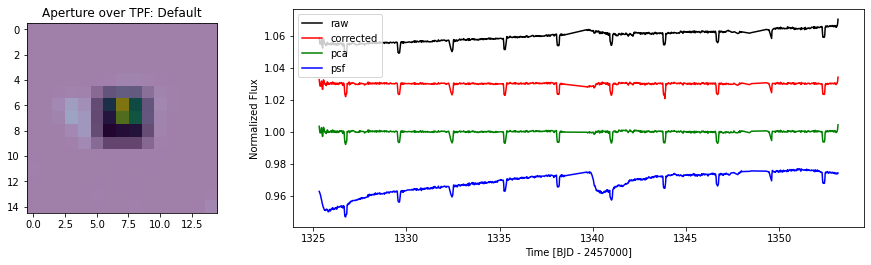

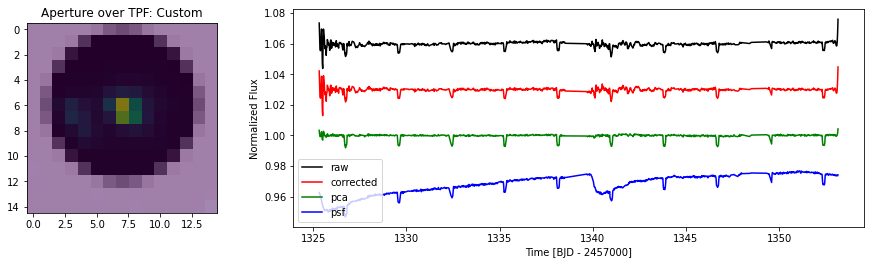

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(dataDefault.tpf[0])
ax1.imshow(dataDefault.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF: Default')

plt.plot(dataDefault.time[qD], dataDefault.raw_flux[qD]/np.nanmedian(dataDefault.raw_flux[qD])+0.06, 'k', label="raw")
plt.plot(dataDefault.time[qD], dataDefault.corr_flux[qD]/np.nanmedian(dataDefault.corr_flux[qD]) + 0.03, 'r', label="corrected")
if (DO_ELEANOR_PCA): plt.plot(dataDefault.time[qD], dataDefault.pca_flux[qD]/np.nanmedian(dataDefault.pca_flux[qD]), 'g', label="pca")
if (DO_ELEANOR_PSF): plt.plot(dataDefault.time[qD], dataDefault.psf_flux[qD]/np.nanmedian(dataDefault.psf_flux[qD]) - 0.03 * DO_ELEANOR_PCA, 'b', label="psf")

ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(dataCustom.tpf[0])
ax1.imshow(dataCustom.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF: Custom')

plt.plot(dataCustom.time[qC], dataCustom.raw_flux[qC]/np.nanmedian(dataCustom.raw_flux[qC])+0.06, 'k', label="raw")
plt.plot(dataCustom.time[qC], dataCustom.corr_flux[qC]/np.nanmedian(dataCustom.corr_flux[qC]) + 0.03, 'r', label="corrected")
if (DO_ELEANOR_PCA): plt.plot(dataCustom.time[qC], dataCustom.pca_flux[qC]/np.nanmedian(dataCustom.pca_flux[qC]), 'g', label="pca")
if (DO_ELEANOR_PSF): plt.plot(dataCustom.time[qC], dataCustom.psf_flux[qC]/np.nanmedian(dataCustom.psf_flux[qC]) - 0.03 * DO_ELEANOR_PCA, 'b', label="psf")

ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

When `eleanor` saves data, it encodes the data as a table where each column is labeled with a string. These strings need to be compatible with the labels that `lightkurve` expects, but by default, they are not. Avi extracted the code below from the `TargetData.save` function and modified so that it is compatible with `lightkurve`.

In [6]:
def save_tpf(data, output_fn=None, directory=None):
        """Saves a created TPF object to a FITS file.

        Parameters
        ----------
        output_fn : str, optional
            Filename to save output as. Overrides default naming.
        directory : str, optional
            Directory to save file into.
        """
        if data.language == 'Australian':
            raise ValueError("These light curves are upside down. Please don't save them ...")
        
        data.set_header()

        # if the user did not specify a directory, set it to default
        if directory is None:
            directory = data.fetch_dir()
            
        raw       = [e+'_raw'  for e in data.aperture_names[:len(data.all_apertures)]]
        errors    = [e+'_err'  for e in data.aperture_names]
        corrected = [e+'_corr' for e in data.aperture_names]

        # Creates table for first extension (tpf, tpf_err, best lc, time, centroids)
        ext1 = Table()
        ext1['TIME']       = data.time
        ext1['TIMECORR']   = data.barycorr
        ext1['FLUX']        = data.tpf
        ext1['FLUX_ERR']    = data.tpf_err
        ext1['RAW_FLUX']   = data.raw_flux
        ext1['CORR_FLUX']  = data.corr_flux
        ext1['RAW_FLUX_ERR']   = data.flux_err
        ext1['QUALITY']    = data.quality
        ext1['X_CENTROID'] = data.centroid_xs
        ext1['Y_CENTROID'] = data.centroid_ys
        ext1['X_COM']      = data.x_com
        ext1['Y_COM']      = data.y_com
        ext1['FLUX_BKG']   = data.flux_bkg
        ext1['CADENCENO']   = data.ffiindex 
        
        
        if data.bkg_type == "PC_LEVEL":
            ext1['FLUX_BKG'] = data.flux_bkg
        else:
            ext1['FLUX_BKG'] = data.flux_bkg + data.tpf_flux_bkg 
        

        if data.pca_flux is not None:
            ext1['PCA_FLUX'] = data.pca_flux
        if data.psf_flux is not None:
            ext1['PSF_FLUX'] = data.psf_flux

        # Creates table for second extension (all apertures)
        ext2 = Table()
        for i in range(len(data.all_apertures)):
            ext2[data.aperture_names[i]] = data.all_apertures[i]

        # Creates table for third extention (all raw & corrected fluxes and errors)
        ext3 = Table()
        for i in range(len(raw)):
            ext3[raw[i]]       = data.all_raw_flux[i]
            ext3[corrected[i]] = data.all_corr_flux[i]
            ext3[errors[i]]    = data.all_flux_err[i]

        # Appends aperture to header
        data.header.append(fits.Card(keyword='APERTURE', value=data.aperture_names[data.best_ind],
                                     comment='Best aperture used for lightcurves in extension 1'))

        # Writes TPF to FITS file
        primary_hdu = fits.PrimaryHDU(header=data.header)
        data_list = [primary_hdu, fits.BinTableHDU(ext1), fits.BinTableHDU(ext2), fits.BinTableHDU(ext3)]
        hdu = fits.HDUList(data_list)

        if output_fn == None:
            path = os.path.join(directory, 'hlsp_eleanor_tess_ffi_tic{0}_s{1:02d}_tess_v{2}_lc.fits'.format(
                    data.source_info.tic, data.source_info.sector, eleanor.__version__))
        else:
            path = os.path.join(directory, output_fn)

        hdu.writeto(path, overwrite=True)

Finally, we wish to save the subtracted data as a FITS file.

In [7]:
save_tpf(dataDefault,output_fn=FITS_NAME+"default.fits",directory = FITS_PATH )
save_tpf(dataCustom,output_fn=FITS_NAME+"custom.fits",directory = FITS_PATH )

## Load the file using `lightkurve`

In [8]:
import lightkurve as lk
from lightkurve.correctors import TessPLDCorrector

Now that we have used `eleanor` to load and save the star's tpf, we would like to load and detrend it using `lightkurve`.

In [9]:
tpfDefault = lk.targetpixelfile.TessTargetPixelFile(FITS_PATH+'/'+FITS_NAME+"default.fits")
tpfCustom = lk.targetpixelfile.TessTargetPixelFile(FITS_PATH+'/'+FITS_NAME+"custom.fits")

Define an aperture and plot it:

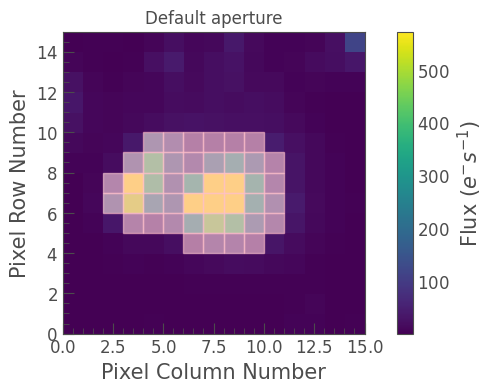

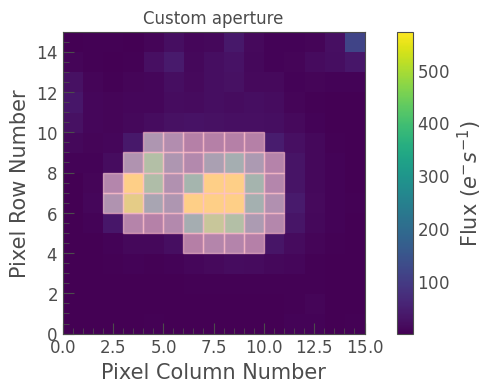

In [10]:
aperDefault = tpfDefault.create_threshold_mask()
p = tpfDefault.plot(aperture_mask=aperDefault);
p.set_title("Default aperture");

aperCustom = tpfCustom.create_threshold_mask()
p = tpfCustom.plot(aperture_mask=aperCustom);
p.set_title("Custom aperture");

Now, we'd like to detrend the lightcurve. There are two methods I have implemented to do this: pca and psf. You can choose which one to use by setting the `CORRECT_MODE` flag below.

In [11]:
lcDefault = tpfDefault.to_lightcurve(aperture_mask=aperDefault)
lcCustom = tpfCustom.to_lightcurve(aperture_mask=aperCustom)
correctedLCDefault = None
correctedLCCustom = None
CORRECT_MODE = "pca"

NUMBER_PCA_COMPONENTS = 1# Supposed to be "much smaller than the" number of stars on the CCD.
    # Originally 5

if CORRECT_MODE == "pca": #(aperture * TPF + background subtraction + cotrending basis vectors)
    dmsDefault = lk.DesignMatrix(tpfDefault.flux[:, ~aperDefault], name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
    dmsCustom = lk.DesignMatrix(tpfCustom.flux[:, ~aperCustom], name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
    correctedLCDefault = lk.RegressionCorrector(lcDefault).correct(dmsDefault)
    correctedLCCustom = lk.RegressionCorrector(lcCustom).correct(dmsCustom)
    
if CORRECT_MODE == "pld":# Don't know what this is, but I think it's similar to PSF.
    correctedLCDefault = TessPLDCorrector(tpfDefault).correct()
    correctedLCCustom = TessPLDCorrector(tpfCustom).correct()

Finally, we plot the lightcurves, corrected and uncorrected.

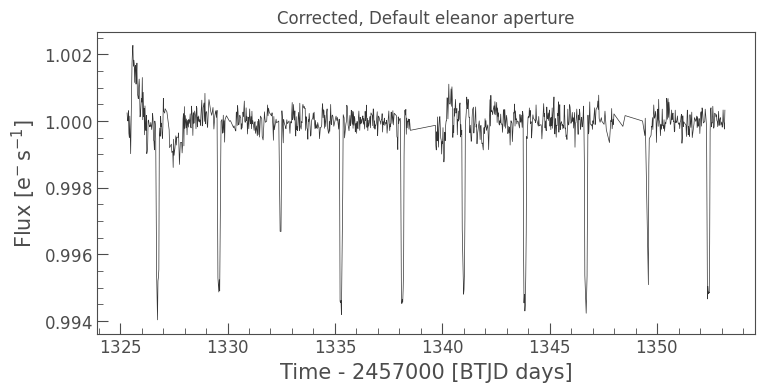

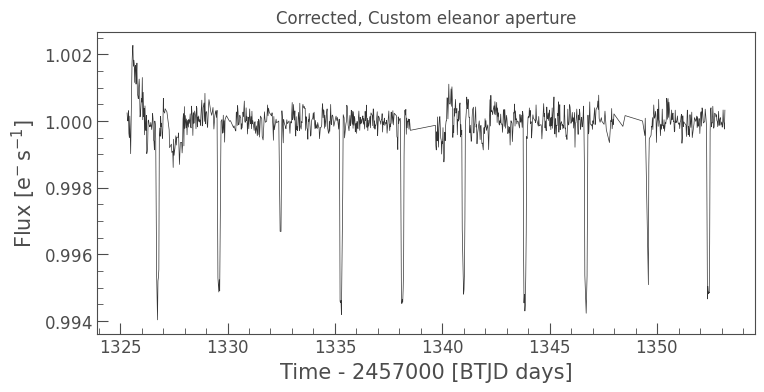

In [12]:
plot2 = correctedLCDefault.flatten().plot();# This is where you would flatten the curves
plot2.set_title("Corrected, Default eleanor aperture");

plot2 = correctedLCCustom.flatten().plot();# This is where you would flatten the curves
plot2.set_title("Corrected, Custom eleanor aperture");